### Data Augmentation

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt  
import librosa.feature  
from scipy.signal import resample
import os  
import numpy as np
import soundfile as sf
from tqdm import tqdm
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import pickle
from PIL import Image
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
def augment_audio_and_save(audio_path, output_dir, num_augmentations=3):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    y, sr = librosa.load(audio_path, sr=None)
    for i in range(num_augmentations):
        augmented_y = y.copy()  
        if np.random.rand() > 0.5:
            rate = np.random.uniform(0.75, 1.25)
            augmented_y = librosa.effects.time_stretch(augmented_y, rate=rate)
        if np.random.rand() > 0.5:
            n_steps = np.random.randint(-3, 4)
            augmented_y = librosa.effects.pitch_shift(augmented_y, sr=sr, n_steps=n_steps)
        if np.random.rand() > 0.5:
            noise = np.random.randn(len(augmented_y))
            augmented_y = augmented_y + 0.005 * noise
        base_filename = os.path.basename(audio_path)
        filename_without_ext, ext = os.path.splitext(base_filename)
        new_filename = f"{filename_without_ext}_aug_{i}{ext}".replace("aac","wav")
        save_path = os.path.join(output_dir, new_filename)
        sf.write(save_path, augmented_y, sr)

#for chord in os.listdir("./ori_c"):
#    for file in tqdm(os.listdir("./ori_c/"+chord)):
#        augment_audio_and_save('./ori_c/{}/{}'.format(chord,file),'./test_c/'+chord)

### define the normalize function

In [2]:

files=['./train_c/am/'+i for i in os.listdir("./train_c/am/")]
def normalize_chroma(chromagram):
    chromagram_resized = resample(chromagram, 224, axis=1)
    chromagram_resized = resample(chromagram_resized, 224, axis=0)
    min_val = np.min(chromagram_resized)
    max_val = np.max(chromagram_resized)
    chromagram_normalized = (chromagram_resized - min_val) / (max_val - min_val) * 255
    chromagram_uint8 = chromagram_normalized.astype(np.uint8)
    return Image.fromarray(chromagram_uint8)
#for file in files:
#	audio,sr=librosa.load(file,sr=None)
#	mfccs=librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=13)

In [ ]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
model = models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

In [4]:
class ChordDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        audio,sr=librosa.load(self.data[idx],sr=None)
        chromagram=librosa.feature.chroma_stft(y=audio, sr=sr)
        return preprocess(normalize_chroma(chromagram)), self.labels[idx]
train_data = []
train_labels = []
test_data=[]
test_labels=[]
labels_dict = {
    "c":0,
    "dm":1,
    "em":2,
    "f":3,
    "g":4,
    "am":5
}
for chord in os.listdir("./train_c"):
    train_data+=["./train_c/{}/{}".format(chord,i) for i in os.listdir("./train_c/"+chord)]
    train_labels+=[labels_dict[chord] for i in os.listdir("./train_c/"+chord)]
for chord in os.listdir("./test_c"):
    test_data+=["./test_c/{}/{}".format(chord,i) for i in os.listdir("./test_c/"+chord)]
    test_labels+=[labels_dict[chord] for i in os.listdir("./test_c/"+chord)]
train_dataset = ChordDataset(train_data, torch.tensor(train_labels))
test_dataset = ChordDataset(test_data, torch.tensor(test_labels))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
def getTestPerformance(model,test_loader):
	model.eval()
	correct=0
	total=0
	#predict/real label pair
	p_r_pair=[]
	for data,target in test_loader:
		total+=len(data)
		data,target=data.to(device),target.to(device)
		output=model(data)
		pred=output.argmax(dim=1,keepdim=True)
		correct+=pred.eq(target.view_as(pred)).sum().item()
		pred=pred.to('cpu')
		pred=pred.reshape(pred.shape[0],).tolist()
		target=target.to('cpu').tolist()
		p_r_pair+=[(pred[i],target[i]) for i in range(len(pred))]
	return correct/total,p_r_pair

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
epoch_losses = []
test_accs = []
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    test_acc,test_pref=getTestPerformance(model, test_loader)
    test_accs.append(test_acc)
    pickle.dump(test_pref,open(f"./log_test/test_pref_epoch_{epoch+1}.pkl","wb"))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}, Learning Rate: {optimizer.param_groups[0]['lr']}, Test Accuracy: {test_acc}")    
    if (epoch + 1) % 5 == 0:
        torch.save(model, f"./log_model/model_epoch_{epoch+1}.pth")

100%|██████████| 60/60 [02:51<00:00,  2.86s/it]  
Epoch 1/20, Loss: 1.608306849002838, Learning Rate: 0.001, Test Accuracy: 0.5238095238095238  
100%|██████████| 60/60 [02:55<00:00,  2.92s/it]  
Epoch 2/20, Loss: 1.1613975624243418, Learning Rate: 0.001, Test Accuracy: 0.6666666666666666  
100%|██████████| 60/60 [02:54<00:00,  2.91s/it]  
Epoch 3/20, Loss: 0.9709225714206695, Learning Rate: 0.001, Test Accuracy: 0.708994708994709  
100%|██████████| 60/60 [02:54<00:00,  2.90s/it]  
Epoch 4/20, Loss: 0.8162032286326091, Learning Rate: 0.001, Test Accuracy: 0.7222222222222222  
100%|██████████| 60/60 [02:50<00:00,  2.84s/it]  
Epoch 5/20, Loss: 0.7528954794009527, Learning Rate: 0.001, Test Accuracy: 0.7433862433862434  
100%|██████████| 60/60 [02:48<00:00,  2.81s/it]  
Epoch 6/20, Loss: 0.7156038045883178, Learning Rate: 0.001, Test Accuracy: 0.7433862433862434  
100%|██████████| 60/60 [02:50<00:00,  2.85s/it]  
Epoch 7/20, Loss: 0.6584367151061694, Learning Rate: 0.001, Test Accuracy: 0.7619047619047619  
100%|██████████| 60/60 [02:49<00:00,  2.82s/it]  
Epoch 8/20, Loss: 0.618238898118337, Learning Rate: 0.001, Test Accuracy: 0.7724867724867724  
100%|██████████| 60/60 [02:55<00:00,  2.92s/it]  
Epoch 9/20, Loss: 0.6053105741739273, Learning Rate: 0.001, Test Accuracy: 0.7671957671957672  
100%|██████████| 60/60 [02:51<00:00,  2.86s/it]  
Epoch 10/20, Loss: 0.5514613290627798, Learning Rate: 0.001, Test Accuracy: 0.7777777777777778  
100%|██████████| 60/60 [02:53<00:00,  2.89s/it]  
Epoch 11/20, Loss: 0.545198488732179, Learning Rate: 0.001, Test Accuracy: 0.7698412698412699  

### train losses

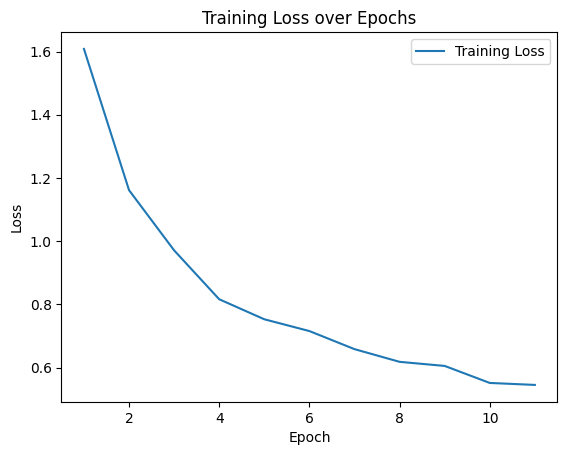

In [14]:
plt.plot(range(1, 12), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

### test acc

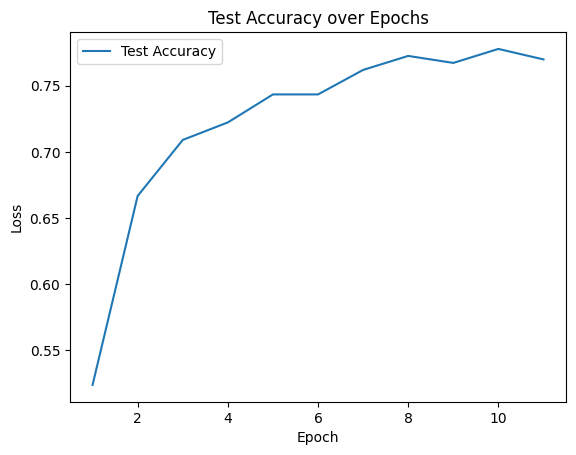

In [19]:
plt.plot(range(1, 12), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

### recall & precision

In [69]:
from sklearn.metrics import classification_report
tmp = pickle.load(open("./log_test/test_pref_epoch_11.pkl", "rb"))
print(classification_report([i[1] for i in tmp], [i[0] for i in tmp]))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        66
           1       0.78      0.82      0.80        60
           2       0.68      0.88      0.77        60
           3       0.83      0.64      0.72        69
           4       0.73      0.78      0.75        63
           5       0.81      0.73      0.77        60

    accuracy                           0.77       378
   macro avg       0.78      0.77      0.77       378
weighted avg       0.78      0.77      0.77       378



### recall & precision alter visualization

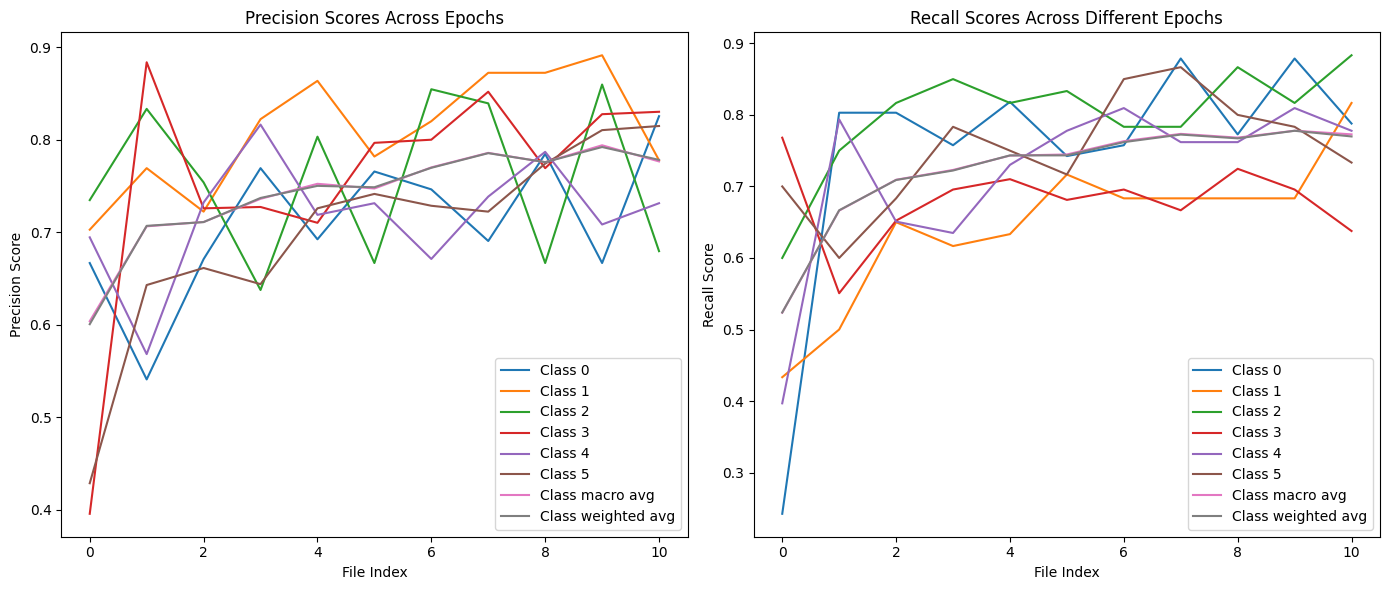

In [68]:
from sklearn.metrics import classification_report
precision_scores = {}
recall_scores = {}
for file in sorted(["./log_test/"+i for i in os.listdir("./log_test/")], key=lambda x: int(x.split('_')[-1].split('.')[0])):
    tmp = pickle.load(open(file, "rb"))
    y_true = [i[1] for i in tmp]
    y_pred = [i[0] for i in tmp]
    report = classification_report(y_true, y_pred, output_dict=True)
    for label, metrics in report.items():
        if label.isdigit() or label in ['macro avg', 'weighted avg']:
            if label not in precision_scores:
                precision_scores[label] = []
                recall_scores[label] = []
            precision_scores[label].append(metrics['precision'])
            recall_scores[label].append(metrics['recall'])
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for label, precisions in precision_scores.items():
    plt.plot(precisions, label=f'Class {label}')
plt.title('Precision Scores Across Epochs')
plt.xlabel('File Index')
plt.ylabel('Precision Score')
plt.legend()
plt.subplot(1, 2, 2)
for label, recalls in recall_scores.items():
    plt.plot(recalls, label=f'Class {label}')
plt.title('Recall Scores Across Different Epochs')
plt.xlabel('File Index')
plt.ylabel('Recall Score')
plt.legend()
plt.tight_layout()
plt.show()

### more preformance visualize

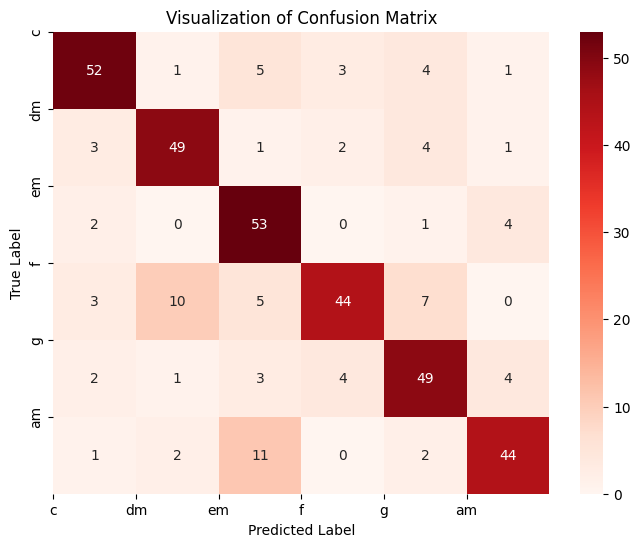

'              precision    recall  f1-score   support\n\n           0       0.83      0.79      0.81        66\n           1       0.78      0.82      0.80        60\n           2       0.68      0.88      0.77        60\n           3       0.83      0.64      0.72        69\n           4       0.73      0.78      0.75        63\n           5       0.81      0.73      0.77        60\n\n    accuracy                           0.77       378\n   macro avg       0.78      0.77      0.77       378\nweighted avg       0.78      0.77      0.77       378\n'

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
tmp=pickle.load(open("./log_test/test_pref_epoch_11.pkl",'rb'))
y_true=[i[1] for i in tmp]
y_pred=[i[0] for i in tmp]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Visualization of Confusion Matrix')
plt.xticks(range(0,6),[i[0] for i in labels_dict.items()])
plt.yticks(range(0,6),[i[0] for i in labels_dict.items()])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()